# Projeto - Mineração de Texto e Web
## Residência Engenharia e Ciência de dados - Samsung/UFPE

### Lucas Couri - lncc2
### Mariama Oliveira - mcso

## Carregando Dados

In [1]:
#Imports
import string
import nltk
from nltk.corpus import stopwords
import pandas as pd
# from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, f1_score
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from sklearn.metrics import pairwise_distances_argmin_min
from scipy.sparse import csr_matrix
from scipy.cluster.vq import vq

import numpy as np
import tensorflow as tf
#from keras.datasets import mnist
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Conv2D, Input
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

import dataset_split 
import networks
import bert
import rm_forest

In [2]:
df = pd.read_csv("reviews_v2.csv")
df = df[df["reviews"].notna()]

## Pré-processamento (com e sem stemming)

In [3]:
#Global variables
other_punctuation = '—“”'  
stop_words = stopwords.words('portuguese')
stop_words.append('’')
stemmer = nltk.stem.RSLPStemmer()


#Function that removes punctuation 
def remove_punctuation(text):
    punctuation_free_doc = "".join([i for i in text if i not in string.punctuation+other_punctuation])
    return punctuation_free_doc


def remove_stopwords(list_words):
    filtered_words = [word for word in list_words if word not in stop_words]
    return filtered_words


def do_stemming(list_words):
    stem_text = [stemmer.stem(word) for word in list_words]
    return stem_text


def pre_process(doc, basic_processing = False, no_stopwords = False, stemming = False):

    final_doc = doc
    
    ## print(final_doc)

    if basic_processing == True:
        
        final_doc = remove_punctuation(doc)
        final_doc = final_doc.lower()

    final_doc = nltk.word_tokenize(final_doc)

    if no_stopwords == True:
        final_doc = remove_stopwords(final_doc)    

    if stemming == True:
        final_doc = do_stemming(final_doc)

    return final_doc

def pre_process_all(df, pre_processing_list):

    for param, index in zip(pre_processing_list, range(len(pre_processing_list))):
        
        df[f"reviews_pipeline_{index}"] = df["reviews"].apply(lambda x: pre_process(x, **param))

    return df

pre_processing_list = [
    {"basic_processing": True, "no_stopwords": True, "stemming": False},
    {"basic_processing": True, "no_stopwords": True, "stemming": True}]

df_pp = pre_process_all(df, pre_processing_list)

## Definindo classe

In [4]:
df_pp["class"] = df_pp["stars"].apply(lambda x : 1 if x >=4 else 0)

## Divisão Train, Validation e Test

In [5]:
#Unbalanced dataset
X_train, X_valid, X_test, y_train, y_valid, y_test = dataset_split.split_data(df_pp)

#Balanced dataset
X_train_b, X_valid_b, X_test_b, y_train_b, y_valid_b, y_test_b = dataset_split.split_data(df_pp, True)

Transformando tokens em string

In [6]:
def tokens_to_string(df):
    X_train_join = []
    X_train_join.append(df["reviews_pipeline_0"].apply(" ".join))
    X_train_join.append(df["reviews_pipeline_1"].apply(" ".join))
    X_train_join[0] = X_train_join[0].to_numpy()
    X_train_join[1] = X_train_join[1].to_numpy()

    return X_train_join

In [7]:
#Unbalanced data
X_train_join = tokens_to_string(X_train)
X_test_join = tokens_to_string(X_test)
X_valid_join = tokens_to_string(X_valid)

#Balanced data
X_train_join_b = tokens_to_string(X_train_b)
X_test_join_b = tokens_to_string(X_test_b)
X_valid_join_b = tokens_to_string(X_valid_b)


# Classificadores 

In [44]:
all_metrics = []

def calc_metrics(y_test, result, name):
    f1_w = f1_0 = f1_score(y_test, result, average="weighted")
    f1_0 = f1_score(y_test, result, average=None)[0]
    f1_1 = f1_score(y_test, result, average=None)[1]
    acc = accuracy_score(y_test, result)
    return (name, acc, f1_0, f1_1, f1_w, result.tolist())


## Random Forest com BoW

In [28]:
def get_bag_of_words(X_train_join, X_valid_join, X_test_join):
    vectorizer = CountVectorizer(analyzer = "word",   
                                tokenizer = None,    
                                preprocessor = None, 
                                stop_words = None,   
                                max_features = 2000) 

    #List with BoWs (pipeline 0 and 1)
    X_train_vec = []
    X_train_vec.append(vectorizer.fit_transform(X_train_join[0]))
    X_train_vec.append(vectorizer.fit_transform(X_train_join[1]))

    X_test_vec = []
    X_test_vec.append(vectorizer.fit_transform(X_test_join[0]))
    X_test_vec.append(vectorizer.fit_transform(X_test_join[1]))

    X_valid_vec = []
    X_valid_vec.append(vectorizer.fit_transform(X_valid_join[0]))
    X_valid_vec.append(vectorizer.fit_transform(X_valid_join[1]))


    return X_train_vec, X_valid_vec, X_test_vec

In [29]:
#Unbalanced data
X_train_vec, X_valid_vec, X_test_vec = get_bag_of_words(X_train_join, X_valid_join, X_test_join)

#Balanced data
X_train_vec_b, X_valid_vec_b, X_test_vec_b = get_bag_of_words(X_train_join_b, X_valid_join_b, X_test_join_b)

In [30]:
def pipeline_rf(name, X_train_vec, y_train, X_valid_vec, y_valid, X_test_vec, y_test):
    #Get best parameters
    best_params = rm_forest.get_best_parameters(X_train_vec, X_valid_vec, y_train, y_valid)
    
    #Train model with best parameters
    forest = RandomForestClassifier(**best_params) 
    forest = forest.fit(X_train_vec, y_train)

    #Predict test datase 
    result = forest.predict(X_test_vec)
    print(classification_report(y_test, result))
    print(confusion_matrix(y_test, result))

    metrics = calc_metrics(y_test, result, name)

    return metrics

### Sem stemming

In [45]:
#Unbalanced data
all_metrics.append(pipeline_rf("rf", X_train_vec[0], y_train, X_valid_vec[0], y_valid, X_test_vec[0], y_test))

[I 2022-03-31 17:04:21,936] A new study created in memory with name: no-name-0c02f9ea-3275-43ec-a156-7dc7cf28aa09
[I 2022-03-31 17:04:23,485] Trial 0 finished with value: 0.0 and parameters: {'n_estimators': 887, 'max_depth': 6, 'criterion': 'entropy'}. Best is trial 0 with value: 0.0.
[I 2022-03-31 17:04:25,082] Trial 1 finished with value: 0.0 and parameters: {'n_estimators': 954, 'max_depth': 4, 'criterion': 'entropy'}. Best is trial 0 with value: 0.0.
[I 2022-03-31 17:04:25,366] Trial 2 finished with value: 0.01639344262295082 and parameters: {'n_estimators': 69, 'max_depth': 39, 'criterion': 'entropy'}. Best is trial 2 with value: 0.01639344262295082.
[I 2022-03-31 17:04:27,877] Trial 3 finished with value: 0.044444444444444446 and parameters: {'n_estimators': 723, 'max_depth': 43, 'criterion': 'gini'}. Best is trial 3 with value: 0.044444444444444446.
[I 2022-03-31 17:04:28,265] Trial 4 finished with value: 0.0 and parameters: {'n_estimators': 206, 'max_depth': 13, 'criterion': '

              precision    recall  f1-score   support

           0       0.28      0.08      0.12       167
           1       0.89      0.97      0.93      1334

    accuracy                           0.87      1501
   macro avg       0.59      0.53      0.53      1501
weighted avg       0.83      0.87      0.84      1501

[[  13  154]
 [  34 1300]]


In [ ]:
#Balanced data
all_metrics.append(pipeline_rf("rf_b",X_train_vec_b[0], y_train_b, X_valid_vec_b[0], y_valid_b, X_test_vec_b[0], y_test_b))

[I 2022-03-31 15:56:41,990] A new study created in memory with name: no-name-9de3d36b-1fe0-4c01-9c52-7a3a69ac6990
[I 2022-03-31 15:56:43,439] Trial 0 finished with value: 0.0 and parameters: {'n_estimators': 940, 'max_depth': 5, 'criterion': 'entropy'}. Best is trial 0 with value: 0.0.
[I 2022-03-31 15:56:43,539] Trial 1 finished with value: 0.0 and parameters: {'n_estimators': 64, 'max_depth': 4, 'criterion': 'gini'}. Best is trial 0 with value: 0.0.
[I 2022-03-31 15:56:43,612] Trial 2 finished with value: 0.0 and parameters: {'n_estimators': 49, 'max_depth': 2, 'criterion': 'gini'}. Best is trial 0 with value: 0.0.
[I 2022-03-31 15:56:43,939] Trial 3 finished with value: 0.0 and parameters: {'n_estimators': 239, 'max_depth': 2, 'criterion': 'gini'}. Best is trial 0 with value: 0.0.
[I 2022-03-31 15:56:45,077] Trial 4 finished with value: 0.0 and parameters: {'n_estimators': 742, 'max_depth': 3, 'criterion': 'entropy'}. Best is trial 0 with value: 0.0.
[I 2022-03-31 15:56:50,498] Tria

              precision    recall  f1-score   support

           0       0.16      0.26      0.20       167
           1       0.90      0.82      0.86      1334

    accuracy                           0.76      1501
   macro avg       0.53      0.54      0.53      1501
weighted avg       0.82      0.76      0.78      1501



### Com stemming

In [25]:
all_metrics.append(pipeline_rf("rf_st",X_train_vec[1], y_train, X_valid_vec[1], y_valid, X_test_vec[1], y_test))

[I 2022-03-31 15:59:16,350] A new study created in memory with name: no-name-251c84ab-1d55-476f-9b1c-4e8fbcaf2858
[I 2022-03-31 15:59:20,691] Trial 0 finished with value: 0.07407407407407407 and parameters: {'n_estimators': 965, 'max_depth': 53, 'criterion': 'entropy'}. Best is trial 0 with value: 0.07407407407407407.
[I 2022-03-31 15:59:22,864] Trial 1 finished with value: 0.032520325203252036 and parameters: {'n_estimators': 598, 'max_depth': 35, 'criterion': 'entropy'}. Best is trial 0 with value: 0.07407407407407407.
[I 2022-03-31 15:59:25,115] Trial 2 finished with value: 0.016666666666666666 and parameters: {'n_estimators': 797, 'max_depth': 25, 'criterion': 'entropy'}. Best is trial 0 with value: 0.07407407407407407.
[I 2022-03-31 15:59:26,030] Trial 3 finished with value: 0.05882352941176471 and parameters: {'n_estimators': 286, 'max_depth': 33, 'criterion': 'gini'}. Best is trial 0 with value: 0.07407407407407407.
[I 2022-03-31 15:59:28,390] Trial 4 finished with value: 0.0746

              precision    recall  f1-score   support

           0       0.21      0.07      0.11       167
           1       0.89      0.97      0.93      1334

    accuracy                           0.87      1501
   macro avg       0.55      0.52      0.52      1501
weighted avg       0.82      0.87      0.84      1501



In [26]:
all_metrics.append(pipeline_rf("rf_b_st",X_train_vec_b[1], y_train_b, X_valid_vec_b[1], y_valid_b, X_test_vec_b[1], y_test_b))

[I 2022-03-31 15:59:48,118] A new study created in memory with name: no-name-33cfd233-a2da-4307-9265-c269fb574187
[I 2022-03-31 15:59:55,098] Trial 0 finished with value: 0.15228426395939085 and parameters: {'n_estimators': 995, 'max_depth': 118, 'criterion': 'gini'}. Best is trial 0 with value: 0.15228426395939085.
[I 2022-03-31 15:59:56,074] Trial 1 finished with value: 0.0 and parameters: {'n_estimators': 410, 'max_depth': 13, 'criterion': 'entropy'}. Best is trial 0 with value: 0.15228426395939085.
[I 2022-03-31 16:00:00,484] Trial 2 finished with value: 0.07547169811320754 and parameters: {'n_estimators': 936, 'max_depth': 42, 'criterion': 'gini'}. Best is trial 0 with value: 0.15228426395939085.
[I 2022-03-31 16:00:04,273] Trial 3 finished with value: 0.028368794326241134 and parameters: {'n_estimators': 871, 'max_depth': 34, 'criterion': 'entropy'}. Best is trial 0 with value: 0.15228426395939085.
[I 2022-03-31 16:00:05,264] Trial 4 finished with value: 0.15609756097560976 and p

              precision    recall  f1-score   support

           0       0.14      0.18      0.16       167
           1       0.89      0.86      0.88      1334

    accuracy                           0.79      1501
   macro avg       0.52      0.52      0.52      1501
weighted avg       0.81      0.79      0.80      1501



## Redes (CNN, LSTM e BERT)

In [9]:
def pipeline_cnn_lstm(tuner_name,X_train, y_train, X_valid, y_valid, X_test, y_test):

    type_nn = tuner_name[:3]
   
    #Encoding sentences
    encoder = networks.sentence_encoder(X_train)

    #Finding best parameters
    tuner = networks.network_tuner(type_nn, encoder, tuner_name)
    
    best_hp = networks.search_network(tuner, X_train, y_train, X_valid, y_valid)

    #Loading best model
    model = networks.get_model(tuner, best_hp)
    stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
    history = model.fit(X_train, y_train, epochs=50, validation_data = (X_valid, y_valid), callbacks=[stop_early])

    #Getting test results
    result = networks.get_test_metrics(model, X_test, y_test)
    networks.plot_acuracy_loss(history)

    metrics = calc_metrics(y_test, result, tuner_name)
    return metrics

### CNN

#### Sem stemming

INFO:tensorflow:Reloading Oracle from existing project tuner\cnn\oracle.json
INFO:tensorflow:Reloading Tuner from tuner\cnn\tuner0.json
Search space summary
Default search space size: 2
dropout_1 (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
None
INFO:tensorflow:Oracle triggered exit
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 64)          64000     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 32)          16416     
________________________________________________________

C:\Users\mcso\anaconda3\envs\tf_gpu\lib\site-packages\keras\backend.py:4993: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


77/77 [==============================] - ETA: 0s - loss: 0.3107 - accuracy: 0.8825

C:\Users\mcso\anaconda3\envs\tf_gpu\lib\site-packages\keras\backend.py:4993: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


77/77 [==============================] - 11s 103ms/step - loss: 0.3107 - accuracy: 0.8825 - val_loss: 0.2721 - val_accuracy: 0.8972
Epoch 2/50
77/77 [==============================] - 2s 21ms/step - loss: 0.1746 - accuracy: 0.9347 - val_loss: 0.2952 - val_accuracy: 0.8811
Epoch 3/50
77/77 [==============================] - 1s 17ms/step - loss: 0.0749 - accuracy: 0.9702 - val_loss: 0.3424 - val_accuracy: 0.8963
Epoch 4/50
77/77 [==============================] - 1s 14ms/step - loss: 0.0251 - accuracy: 0.9902 - val_loss: 0.4422 - val_accuracy: 0.9020
Epoch 5/50
77/77 [==============================] - 1s 14ms/step - loss: 0.0072 - accuracy: 0.9984 - val_loss: 0.5474 - val_accuracy: 0.8991
Epoch 6/50
47/47 [==============================] - 1s 25ms/step - loss: 0.6876 - accuracy: 0.8967
Test Loss: 0.687615156173706
Test Accuracy: 0.8967354893684387
              precision    recall  f1-score   support

           0       0.58      0.25      0.35       167
           1       0.91      0.98

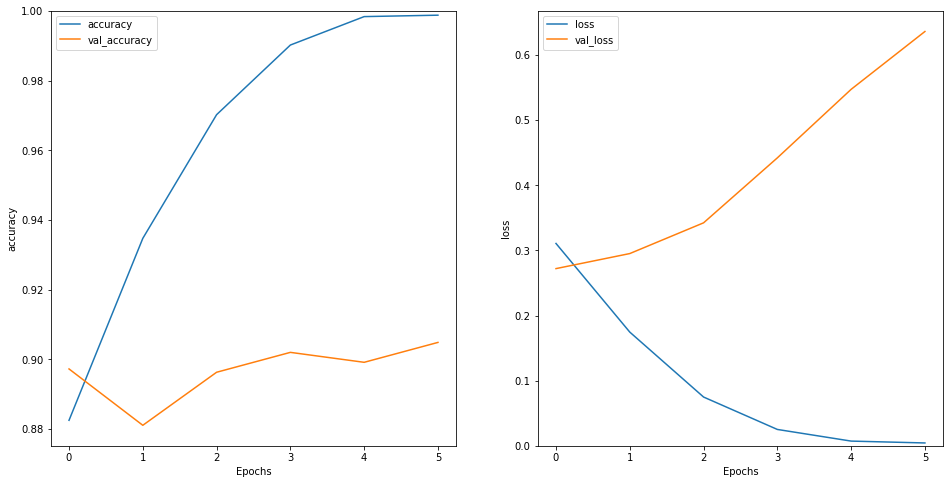

In [10]:
# Desbalanceado
all_metrics.append(pipeline_cnn_lstm("cnn",X_train_join[0], y_train, X_valid_join[0], y_valid, X_test_join[0], y_test))

In [ ]:
# Balanceado
all_metrics.append(pipeline_cnn_lstm("cnn_b",X_train_join_b[0], y_train_b, X_valid_join_b[0], y_valid_b, X_test_join_b[0], y_test_b))

#### Com stemming

In [ ]:
#Desbalanceado
all_metrics.append(pipeline_cnn_lstm("cnn_st",X_train_join[1], y_train, X_valid_join[1], y_valid, X_test_join[1], y_test))

In [ ]:
#Balanceado
all_metrics.append(pipeline_cnn_lstm("cnn_b_st",X_train_join_b[1], y_train_b, X_valid_join_b[1], y_valid_b, X_test_join_b[1], y_test_b))

### LSTM

#### Sem stemming

Trial 3 Complete [00h 00m 19s]
val_accuracy: 0.8886774778366089

Best val_accuracy So Far: 0.9096099138259888
Total elapsed time: 00h 00m 59s
INFO:tensorflow:Oracle triggered exit
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_1 (TextVe (None, None)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 64)          64000     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               66048     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 130,177
Trainable params: 130,177
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
75/77 [============================>.] - ETA: 0s -

C:\Users\mcso\anaconda3\envs\tf_gpu\lib\site-packages\keras\backend.py:4993: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


77/77 [==============================] - 13s 69ms/step - loss: 0.4208 - accuracy: 0.8849 - val_loss: 0.3058 - val_accuracy: 0.8887
Epoch 2/50
77/77 [==============================] - 2s 31ms/step - loss: 0.2383 - accuracy: 0.9053 - val_loss: 0.2367 - val_accuracy: 0.9106
Epoch 3/50
77/77 [==============================] - 2s 32ms/step - loss: 0.1643 - accuracy: 0.9315 - val_loss: 0.2494 - val_accuracy: 0.9106
Epoch 4/50
77/77 [==============================] - 2s 32ms/step - loss: 0.1246 - accuracy: 0.9535 - val_loss: 0.2624 - val_accuracy: 0.9049
Epoch 5/50
77/77 [==============================] - 2s 33ms/step - loss: 0.0947 - accuracy: 0.9653 - val_loss: 0.2931 - val_accuracy: 0.8963
Epoch 6/50
77/77 [==============================] - 2s 32ms/step - loss: 0.0741 - accuracy: 0.9723 - val_loss: 0.3215 - val_accuracy: 0.8991
Epoch 7/50
47/47 [==============================] - 1s 12ms/step - loss: 0.4465 - accuracy: 0.8847
Test Loss: 0.446540892124176
Test Accuracy: 0.8847435116767883
  

('lstm',
 0.8840772818121253,
 0.4041095890410959,
 0.9357933579335793,
 0.8766386681234228)

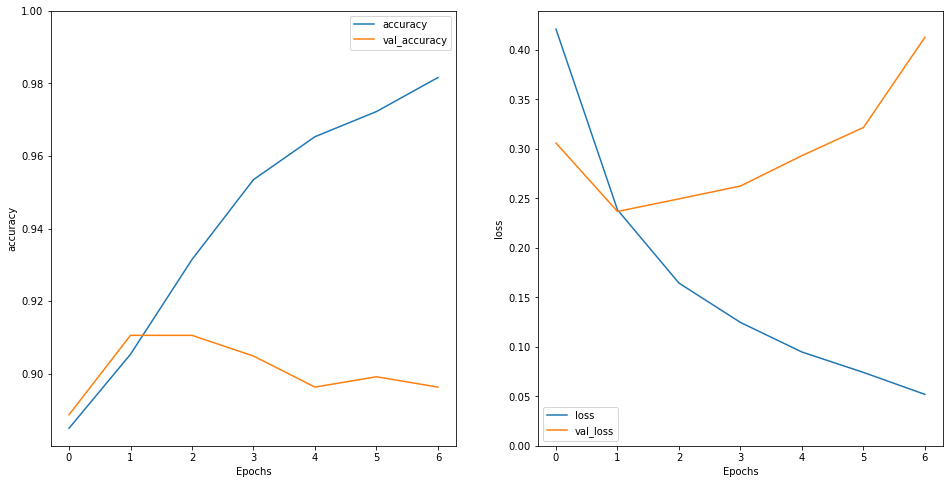

In [12]:
# Desbalanceado
all_metrics.append(pipeline_cnn_lstm("lstm",X_train_join[0], y_train, X_valid_join[0], y_valid, X_test_join[0], y_test))

In [ ]:
# Balanceado
all_metrics.append(pipeline_cnn_lstm("lstm_b",X_train_join_b[0], y_train_b, X_valid_join_b[0], y_valid_b, X_test_join_b[0], y_test_b))

#### Com stemming

In [ ]:
#Desbalanceado
all_metrics.append(pipeline_cnn_lstm("lstm_st",X_train_join[1], y_train, X_valid_join[1], y_valid, X_test_join[1], y_test))

In [ ]:
#Balanceado
all_metrics.append(pipeline_cnn_lstm("lstm_b_st",X_train_join_b[1], y_train_b, X_valid_join_b[1], y_valid_b, X_test_join_b[1], y_test_b))

### BERT

In [13]:
from transformers import TFBertForSequenceClassification

def pipeline_bert(name, X_train, y_train, X_valid, y_valid, X_test, y_test):

    learning_rate = 2e-5
    number_of_epochs = 1
    ds_train, ds_valid, ds_test = bert.get_bert_data(X_train, y_train, X_valid, y_valid, X_test, y_test)
    
    # model initialization
    model = TFBertForSequenceClassification.from_pretrained('bert-base-portuguese-cased', from_pt = True)

    # choosing Adam optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-08)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
    model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

    #Training model
    bert_history = model.fit(ds_train, epochs=number_of_epochs, validation_data=ds_valid)

    #Predict test data
    result = bert.get_test_metrics(model, ds_test, y_test)

    metrics = calc_metrics(y_test, result, name)
    return metrics
    

#### Sem stemming

In [14]:
#Unbalanced data
all_metrics.append(pipeline_bert("bert", X_train_join[0], y_train, X_valid_join[0], y_valid, X_test_join[0], y_test))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\mcso\anaconda3\envs\tf_gpu\lib\site-packages\transformers\tokenization_utils_base.py:2251: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
All PyTorch model weights were used when initializing TFBertForSequenceClassification

100/100 [==============================] - 57s 384ms/step - loss: 0.4441 - accuracy: 0.8500 - val_loss: 0.2965 - val_accuracy: 0.9000
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.88      1.00      0.94        88

    accuracy                           0.88       100
   macro avg       0.44      0.50      0.47       100
weighted avg       0.77      0.88      0.82       100

[[ 0 12]
 [ 0 88]]


C:\Users\mcso\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mcso\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mcso\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#Unbalanced data
all_metrics.append(pipeline_bert("bert", X_train_join_b[0], y_train_b, X_valid_join_b[0], y_valid_b, X_test_join_b[0], y_test_b))

#### Com stemming

In [ ]:
#Unbalanced data
all_metrics.append(pipeline_bert("bert_st",X_train_join[1], y_train, X_valid_join[1], y_valid, X_test_join[1], y_test))

In [ ]:
#Balanced data
all_metrics.append(pipeline_bert("bert_b_st", X_train_join_b[1], y_train_b, X_valid_join_b[1], y_valid_b, X_test_join_b[1], y_test_b))

#### Salvando resultados das métricas

In [48]:
df_metrics = pd.DataFrame(all_metrics, columns=['name', 'accuracy', 'f1_0', 'f1_1', 'f1_w','predictions'])
df_metrics.to_csv("metrics.csv", index= False)

In [49]:
df = pd.read_csv("metrics.csv")

In [50]:
df.head()

,name,accuracy,f1_0,f1_1,f1_w,predictions
0,rf,0.87475,0.121495,0.932568,0.842329,"[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


## Clustering para encontrar as reviews mais representativas

In [ ]:
df_cluster = df_pp[["reviews", "reviews_pipeline_0", "class"]]

X_join = df_cluster["reviews_pipeline_0"].apply(" ".join)
X_join = X_join.to_numpy()

vectorizer = CountVectorizer(analyzer = "word",   
                             tokenizer = None,    
                             preprocessor = None, 
                             stop_words = None,   
                             max_features = 2000) 


bow_vec = vectorizer.fit_transform(X_join)

In [19]:
words = vectorizer.get_feature_names()

kmeans = KMeans(n_clusters = 2, random_state = 420)

kmeans.fit(bow_vec)

NameError: name 'vectorizer' is not defined

In [ ]:
kmeans.cluster_centers_

#### Achar os n mais proximos

- Reviews mais próximas do centróide da classe 0 (Ruim)

In [ ]:
n=2
d = kmeans.transform(csr_matrix.toarray(bow_vec))[:, 0] #distancia de cada ponto ao centroide 0
ind0 = np.argsort(d)[::][:n]
ind0
#csr_matrix.toarray(bow_vec)[ind]

In [ ]:
lista_neg = []
for i in ind0.tolist():
    lista_neg.append(df_pp.iloc[i]["reviews"])
lista_neg

- Reviews mais próximas do centróide da classe 1 (Bom)

In [ ]:
n = 2
d = kmeans.transform(csr_matrix.toarray(bow_vec))[:, 1] #distancia de cada ponto ao centroide 1
ind1 = np.argsort(d)[::][:n]
ind1

In [ ]:
lista_posi = []
for i in ind1.tolist():
    lista_posi.append(df_pp.iloc[i]["reviews"])
lista_posi

Salvando em um df para incluir no dashboard

In [ ]:
df_rep = pd.DataFrame(data={"negativo": lista_neg, "positivo": lista_posi})
df_rep.to_csv("reviews_rep.csv", index=False)

## Função para salvar predições do melhor classificador

In [ ]:
#X_test["pred"] = result
#df_pred = pd.merge(X_test[["class", "pred"]], df_pp[["reviews", "stars", "dates"]], left_index=True, right_index=True)
#df_pred.to_csv("best_pred.csv", index=False)

def save_results(result, X_test, df_pp, dfname="best_pred.csv"):
    X_test["pred"] = result
    df_pred = pd.merge(X_test[["class", "pred"]], df_pp[["reviews", "stars", "dates"]], left_index=True, right_index=True)
    df_pred.to_csv(dfname, index=False)

save_results(result, X_test, df_pp)

In [ ]:
pd.read_csv("best_pred.csv")